整体建议：
  - 配色方案：使用一致的配色，如蓝色系表示节点，红色系表示目标
  - 字体大小：标题14pt，正文12pt，标注10pt
  - 图表尺寸：每个步骤图建议16:9比例，便于PPT展示
  - 连接线：使用箭头显示数据流向和处理顺序

使用字体: Noto Sans CJK JP  (来自: /usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc)


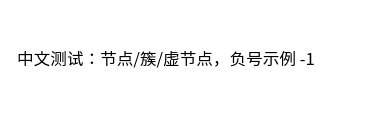

'Noto Sans CJK JP'

In [1]:
# 全局中文字体设置（先运行本单元）
import os
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib.font_manager import FontProperties

# 1) 强制刷新 Matplotlib 字体缓存，确保系统新装字体可被识别
try:
    font_manager._load_fontmanager(try_read_cache=False)  # 私有API，但最直接有效
except Exception:
    pass

# 2) 会话内动态注册常见 CJK 字体文件（Noto/思源/文泉驿/SimHei 等）
font_globs = [
    '/usr/share/fonts/**/NotoSansCJK*.*',
    '/usr/share/fonts/**/SourceHanSans*.*',
    '/usr/share/fonts/**/WenQuanYi*.*',
    '/usr/share/fonts/**/SimHei*.*',
    '/usr/share/fonts/**/msyh*.*',  # 微软雅黑
]
font_paths = []
for pattern in font_globs:
    font_paths.extend(glob.glob(pattern, recursive=True))

registered_names = []
for p in font_paths:
    try:
        # 新版 Matplotlib 支持 addfont，会话内注册字体
        font_manager.fontManager.addfont(p)
        name = FontProperties(fname=p).get_name()
        registered_names.append((name, p))
    except Exception:
        # 旧版可能不支持 addfont，忽略
        pass

# 3) 选择字体并生效
def set_chinese_font(preferred=None, show_sample=True):
    candidates = [
        preferred,
        'Noto Sans CJK SC', 'Noto Sans CJK', 'Source Han Sans SC', 'Source Han Sans',
        'WenQuanYi Micro Hei', 'SimHei', 'Microsoft YaHei', 'PingFang SC', 'STHeiti',
        'Sarasa UI SC', 'LXGW WenKai', 'Arial Unicode MS'
    ]
    candidates = [c for c in candidates if c]

    available = {f.name for f in font_manager.fontManager.ttflist}
    lower_map = {name.lower(): name for name in available}

    chosen = None
    # 精确命中
    for name in candidates:
        if name in available:
            chosen = name
            break
    # 模糊命中
    if not chosen:
        keys = ['noto', 'cjk', 'source han', 'wenquanyi', 'simhei', 'yahei', 'pingfang', 'stheiti', 'sarasa', 'lxgw']
        for key in keys:
            for low, real in lower_map.items():
                if key in low:
                    chosen = real
                    break
            if chosen:
                break

    if chosen:
        mpl.rcParams['font.sans-serif'] = [chosen]
        mpl.rcParams['font.family'] = 'sans-serif'
        mpl.rcParams['axes.unicode_minus'] = False
        # 打印路径（若本次会话动态注册到）
        reg_path = next((p for n, p in registered_names if n == chosen), None)
        if reg_path:
            print(f'使用字体: {chosen}  (来自: {reg_path})')
        else:
            print(f'使用字体: {chosen}')
        if show_sample:
            plt.figure(figsize=(4.8, 1.3))
            plt.text(0.02, 0.5, '中文测试：节点/簇/虚节点，负号示例 -1', fontsize=12, va='center')
            plt.axis('off')
            plt.show()
        return chosen
    else:
        print('未找到常见中文字体，可能仍会显示为方块。建议安装 Noto Sans CJK 或 Source Han Sans。')
        return None

set_chinese_font(preferred='Noto Sans CJK SC')


1. 异构场景分析示意图

  绘图元素：

  节点表示：
  - 使用不同颜色的圆形/方形表示节点（如红、蓝、绿、黄）
  - 大小表示数据量：大圆=数据多，小圆=数据少
  - 分布在画布的不同区域（模拟地理分布）

  数据分布图：
  - 每个节点旁边放置小的柱状图/饼图
  - X轴：类别1-10，Y轴：样本数量
  - 用不同高度/角度显示分布差异

  标注文字：
  - "节点A：城市场景，类别1-3占主导"
  - "节点B：郊区场景，类别4-7较多"
  - "节点C：工业场景，类别8-10集中"

  挑战框：
  - 底部红色框："传统方法：从N=1000个节点选S=100个，复杂度C(1000,100)≈10^
  139"

  绘制步骤：

  1. 画10-15个不同大小颜色的节点
  2. 为每个节点绘制数据分布小图
  3. 用虚线连接相似的节点（预示聚类）
  4. 添加标题"异构环境下的节点数据分布差异"

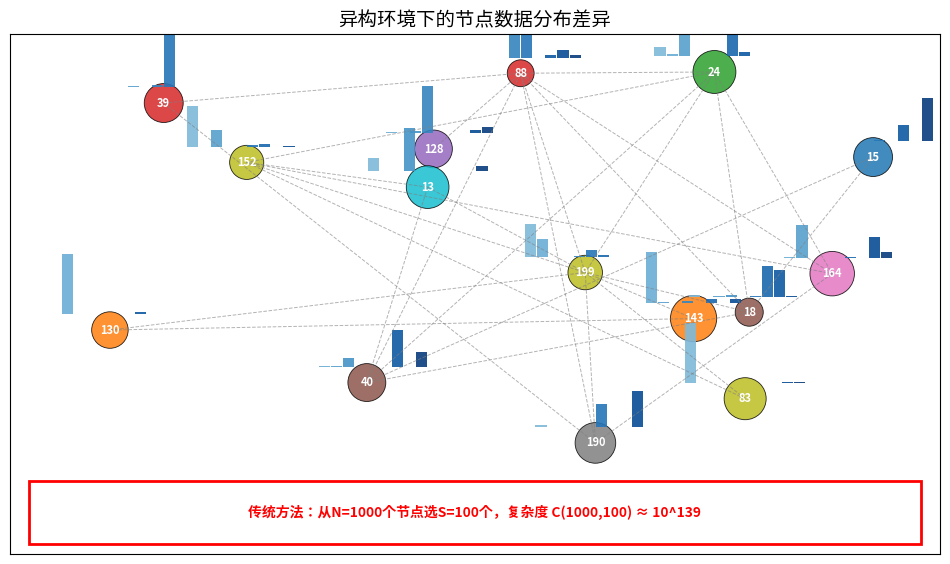

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# 1) 异构场景分析示意图
# 读取聚类与分布数据
with open('/home/liruobin/FL/FederatedScope/draw/peer_communities.json', 'r') as f:
    data = json.load(f)
train = np.array(data['train_distributions'], dtype=float)  # (num_clients, num_classes)
communities = data['peer_communities']  # list of lists
num_clients, num_classes = train.shape

# 映射 client -> community
client_to_comm = {}
for comm_idx, members in enumerate(communities):
    for m in members:
        client_to_comm[m] = comm_idx

# 选择 15 个代表性节点（每个簇选一个代表 + 随机补齐）
rng = np.random.default_rng(42)
selected = []
for comm_idx, members in enumerate(communities):
    if len(selected) >= 15:
        break
    if members:
        # 选该簇中样本数最多的作为代表
        totals = [(m, float(train[m].sum())) for m in members]
        rep = max(totals, key=lambda x: x[1])[0]
        if rep not in selected:
            selected.append(rep)
# 若不足 15，随机补齐
remaining = [i for i in range(num_clients) if i not in selected]
if len(selected) < 15 and len(remaining) > 0:
    pad = min(15 - len(selected), len(remaining))
    selected += list(rng.choice(remaining, size=pad, replace=False))

# 为节点生成二维位置（0-1 归一化坐标，便于在 Axes 坐标系中绘制）
xs = rng.uniform(0.05, 0.95, size=len(selected))
ys = rng.uniform(0.18, 0.95, size=len(selected))  # 预留底部注释空间

# 大小与颜色
totals = train[selected].sum(axis=1)
sizes = (np.sqrt(np.maximum(totals, 1.0)) + 5.0) * 30.0
colors = [plt.cm.tab10(client_to_comm.get(i, 0) % 10) for i in selected]

fig, ax = plt.subplots(figsize=(12, 6.75))
sc = ax.scatter(xs, ys, s=sizes, c=colors, alpha=0.85, edgecolor='k', linewidths=0.6)

# 在每个节点附近绘制微型柱状图，展示该节点的类别分布（归一化后）
for i, x, y in zip(selected, xs, ys):
    dist = train[i].copy()
    if dist.sum() <= 0:
        dist = np.ones_like(dist)
    dist = dist / dist.sum()

    # 在 Axes 坐标中直接画 10 根很小的柱（固定大小，避免随缩放变化）
    num_c = len(dist)
    bar_w = 0.012  # Axes 坐标中的宽度
    gap = 0.001
    base_x = x - (num_c * (bar_w + gap) - gap) / 2
    base_y = y + 0.03
    for k in range(num_c):
        height = float(dist[k]) * 0.12  # Axes 坐标中的高度
        rect = Rectangle((base_x + k * (bar_w + gap), base_y), bar_w, height,
                         transform=ax.transAxes, facecolor=plt.cm.Blues(0.45 + 0.5 * (k / max(1, num_c-1))),
                         alpha=0.9, linewidth=0)
        ax.add_patch(rect)

    # 节点ID标注
    ax.text(x, y, f'{i}', fontsize=8, ha='center', va='center', color='white', weight='bold')

# 相似节点（基于分布的欧氏距离最小）之间画虚线
norms = train[selected]
norms = norms / np.clip(norms.sum(axis=1, keepdims=True), 1e-9, None)
from itertools import combinations
pairs = []
for (a, b) in combinations(range(len(selected)), 2):
    d = float(np.linalg.norm(norms[a] - norms[b]))
    pairs.append((d, a, b))
pairs.sort(key=lambda t: t[0])
for d, a, b in pairs[:30]:  # 连线数量控制在 30 对以内
    ax.plot([xs[a], xs[b]], [ys[a], ys[b]], ls='--', lw=0.7, color='gray', alpha=0.6)

# 美化及标题
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_title('异构环境下的节点数据分布差异', fontsize=14)

# 底部红色框与复杂度说明
frame = Rectangle((0.02, 0.02), 0.96, 0.12, transform=ax.transAxes, fill=False, ec='red', lw=2)
ax.add_patch(frame)
ax.text(0.5, 0.08,
        '传统方法：从N=1000个节点选S=100个，复杂度 C(1000,100) ≈ 10^139',
        transform=ax.transAxes, ha='center', va='center', color='red', fontsize=10, weight='bold')

plt.show()


2. 聚类划分示意图

  绘图元素：

  散点图：
  - X轴：特征维度1，Y轴：特征维度2
  - 每个点代表一个节点，用节点ID标注
  - 点的颜色表示最终所属簇

  聚类结果：
  - 用不同颜色的虚线圆圈圈出各个簇
  - 簇1：红色圆圈，包含节点1,3,7,12
  - 簇2：蓝色圆圈，包含节点2,8,15,20
  - 簇3：绿色圆圈，包含节点5,9,11,18

  层次聚类树：
  - 右侧绘制dendogram树状图
  - 显示节点如何逐步合并成簇
  - Y轴表示聚类距离

  算法框：
  - "层次聚类算法"
  - "相似度计算：欧几里得距离"
  - "复杂度：O(N³)，仅执行一次"

  绘制步骤：

  1. 绘制20-30个散点，呈现3-4个明显的cluster
  2. 用彩色虚线圈出各簇
  3. 右侧画层次聚类树
  4. 添加算法说明框

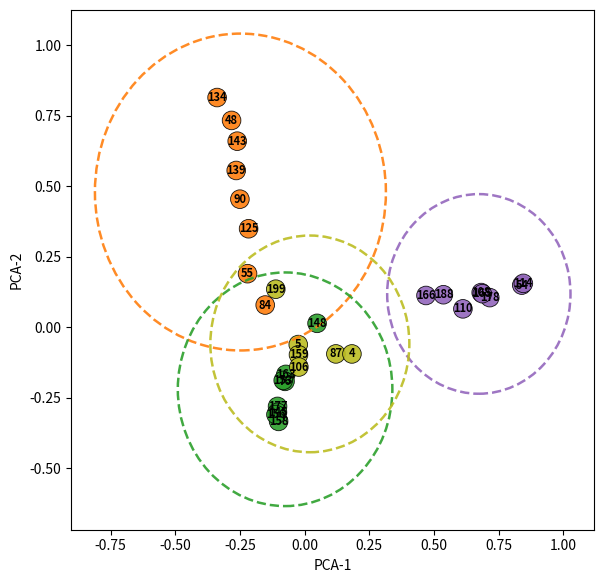

/home/liruobin/miniconda3/envs/fs/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


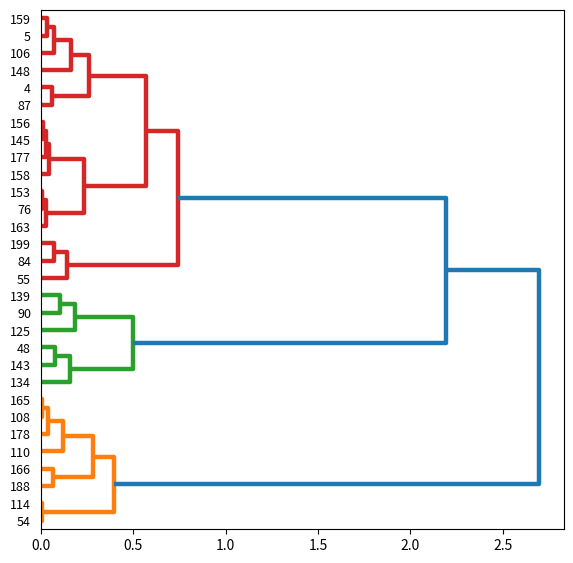

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Circle

# 2) 聚类划分示意图
with open('/home/liruobin/FL/FederatedScope/draw/peer_communities.json', 'r') as f:
    data = json.load(f)
train = np.array(data['train_distributions'], dtype=float)
communities = data['peer_communities']
num_clients, num_classes = train.shape

# client -> community
client_to_comm = {}
for ci, members in enumerate(communities):
    for m in members:
        client_to_comm[m] = ci

# 归一化特征
X = train.copy()
row_sums = X.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1.0
X = X / row_sums

# 使用 numpy 实现 PCA 到二维
Xc = X - X.mean(axis=0, keepdims=True)
U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
components = Vt[:2]
X2 = Xc @ components.T  # (num_clients, 2)

# 选取 30 个样本，尽量来自 3-4 个簇以便更清晰的圈定
# 选择前 4 个簇各取最多 8 个样本，其余随机补足
rng = np.random.default_rng(7)
cluster_order = sorted(range(len(communities)), key=lambda c: len(communities[c]), reverse=True)
chosen = []
for c in cluster_order[:4]:
    members = communities[c]
    if len(members) > 0:
        take = min(8, len(members))
        chosen += list(rng.choice(members, size=take, replace=False))
if len(chosen) < 30:
    rest = [i for i in range(num_clients) if i not in chosen]
    pad = min(30 - len(chosen), len(rest))
    if pad > 0:
        chosen += list(rng.choice(rest, size=pad, replace=False))
else:
    chosen = chosen[:30]

Z = X2[chosen]
labels = [client_to_comm.get(i, 0) for i in chosen]

# 图1：散点 + 圈定 + 算法说明框（独立图）
fig1, ax = plt.subplots(figsize=(6.75, 6.75))

# 散点图
colors = [plt.cm.tab10(l % 10) for l in labels]
ax.scatter(Z[:, 0], Z[:, 1], c=colors, s=180, edgecolor='k', linewidths=0.6, alpha=0.9)
for (x, y), cid in zip(Z, chosen):
    ax.text(x, y, str(cid), fontsize=8, ha='center', va='center', color='black', weight='bold')

# 用虚线圆圈圈出每个簇（按选择样本中的簇均值与最大半径画圆）
unique_clusters = sorted(set(labels))
for c in unique_clusters:
    idx = [i for i, l in enumerate(labels) if l == c]
    pts = Z[idx]
    center = pts.mean(axis=0)
    radii = np.linalg.norm(pts - center, axis=1)
    R = (radii.max() if len(radii) > 0 else 0.5) + 0.15
    circ = Circle(center, R, fill=False, ls='--', lw=1.8, ec=plt.cm.tab10(c % 10), alpha=0.9)
    ax.add_patch(circ)

# ax.set_title('聚类划分（散点+圈定）', fontsize=13)
ax.set_xlabel('PCA-1')
ax.set_ylabel('PCA-2')

# 算法说明框
# algo_text = (
#     '层次聚类算法\n'
#     '相似度计算：欧几里得距离\n'
#     '复杂度：O(N^3)，仅执行一次'
# )
# ax.text(0.02, 0.98, algo_text, transform=ax.transAxes, ha='left', va='top', fontsize=10,
#         bbox=dict(boxstyle='round', fc='white', ec='black', alpha=0.8))

plt.show()

# 图2：层次聚类树（独立图）
fig2, ax_d = plt.subplots(figsize=(6.75, 6.75))
# ax_d.set_title('层次聚类树 (dendrogram)')
try:
    from scipy.cluster.hierarchy import linkage, dendrogram
    from matplotlib.collections import LineCollection
    Z_link = linkage(Z, method='ward', metric='euclidean')
    ddata = dendrogram(
        Z_link,
        labels=[str(i) for i in chosen],
        orientation='right',
        ax=ax_d,
        leaf_font_size=9,
        color_threshold=None,
    )
    # 加粗所有线条（Line2D + LineCollection）
    for line in ax_d.get_lines():
        line.set_linewidth(3.2)
        try:
            line.set_solid_capstyle('round')
        except Exception:
            pass
    for coll in ax_d.collections:
        try:
            coll.set_linewidth(3.2)
        except Exception:
            try:
                coll.set_linewidths(3.2)
            except Exception:
                pass
except Exception as e:
    ax_d.text(0.5, 0.5, '需要 SciPy 才能绘制\n层次聚类树', ha='center', va='center', fontsize=12)
    ax_d.axis('off')

plt.show()


3. 模板构建示意图

  绘图元素：

  任务目标分布（左侧）：
  - 饼图显示期望的类别分布
  - 类别1：30%，类别2：25%，类别3：20%，类别4：15%，类别5：10%
  - 标题："任务目标数据分布"

  各簇特征（中间）：
  - 簇1：柱状图显示其数据分布
  - 簇2：柱状图显示其数据分布
  - 簇3：柱状图显示其数据分布
  - 每个簇用不同颜色框包围

  优化求解（右侧）：
  - 数学公式框：
  min Σ|target_i - Σ(w_j × cluster_j_i)|
  s.t. Σw_j = 1, w_j ≥ 0
  - "二分分解方法"
  - "Gurobi求解器"

  结果输出（底部）：
  - "簇1贡献40%，簇2贡献35%，簇3贡献25%"
  - 最终合成分布柱状图

  绘制步骤：

  1. 左侧画目标分布饼图
  2. 中间画3-4个簇的分布柱状图
  3. 用箭头连接显示优化过程
  4. 右侧添加数学公式和算法框
  5. 底部显示优化结果

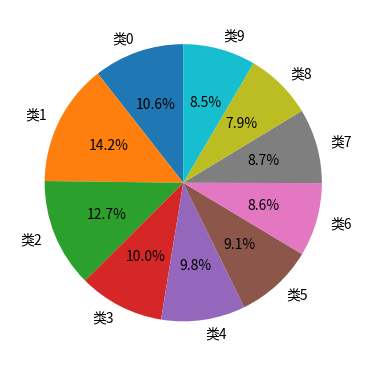

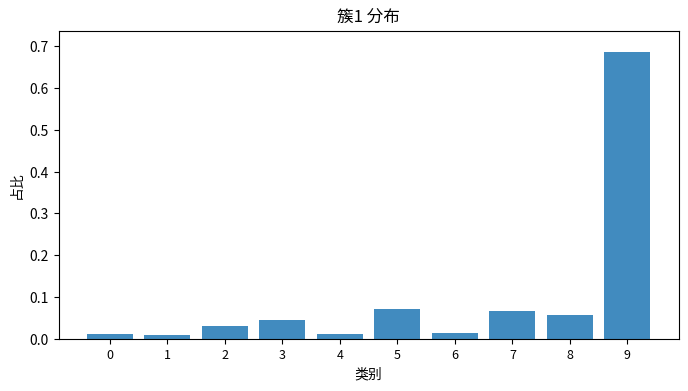

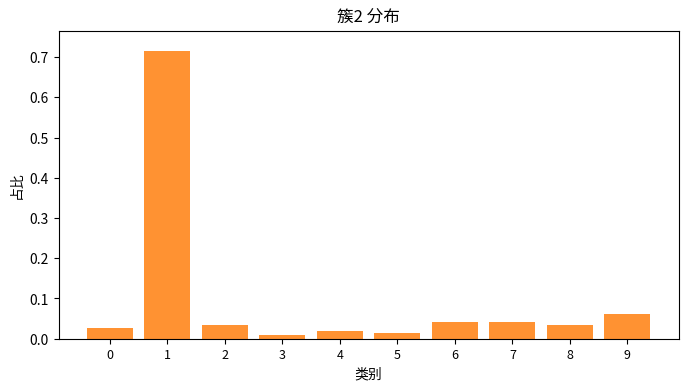

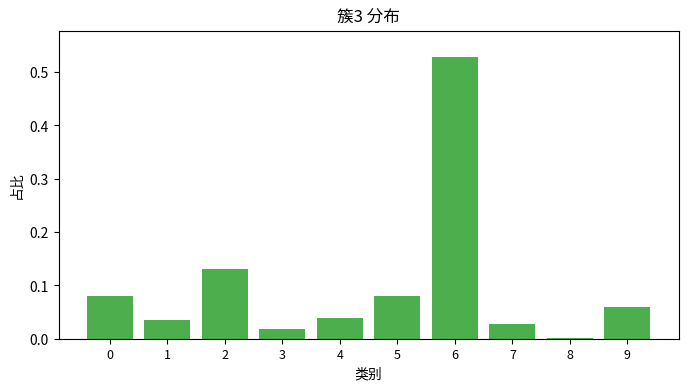

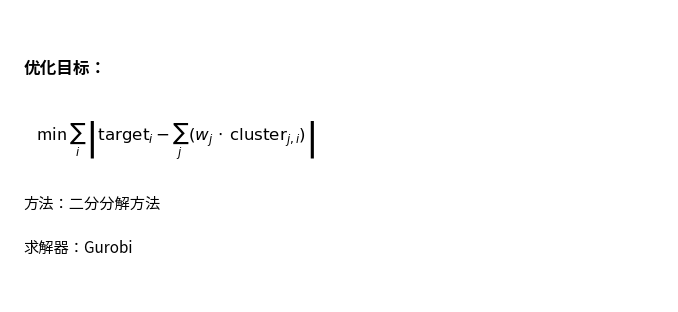

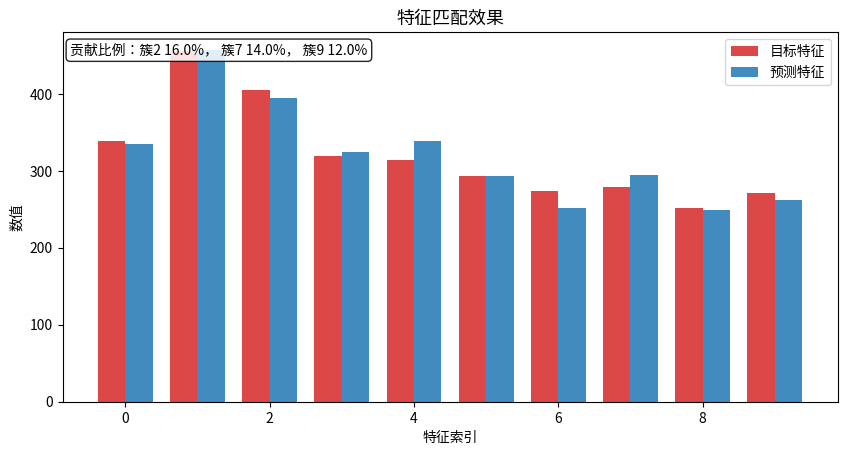

In [4]:
import re
import numpy as np
import matplotlib.pyplot as plt

# 3) 模板构建示意图：读取 slove.txt 并可视化（拆分为多个独立图）
log_path = '/home/liruobin/FL/FederatedScope/draw/slove.txt'
with open(log_path, 'r', encoding='utf-8') as f:
    log_txt = f.read()

# 解析信息
m_target_dist = re.search(r"Target distribution:\s*\[([^\]]+)\]", log_txt)
target_dist = np.array([float(x) for x in m_target_dist.group(1).split()]) if m_target_dist else None

pc_matches = re.findall(r"PC #(\d+)\s*\([^\)]*\):\s*\[([^\]]+)\]", log_txt)
pc_features = {int(idx): np.array([float(v) for v in vec.split()]) for idx, vec in pc_matches}

m_pred = re.search(r"Predicted features:\s*\[([^\]]+)\]", log_txt)
m_tfea = re.search(r"Target features:\s*\[([^\]]+)\]", log_txt)
pred_features = np.array([float(x) for x in m_pred.group(1).split()]) if m_pred else None
tfea = np.array([float(x) for x in m_tfea.group(1).split()]) if m_tfea else None

m_h = re.search(r"Template solved successfully: h = \[([^\]]+)\]", log_txt)
h = np.array([float(x.strip().rstrip('.')) if x.strip().endswith('.') else float(x) for x in m_h.group(1).split()]) if m_h else None

# 辅助函数
def norm_vec(v: np.ndarray) -> np.ndarray:
    s = float(np.sum(v))
    return (v / s) if s > 0 else np.zeros_like(v)

# 图A：目标分布饼图
if target_dist is not None:
    fig, ax = plt.subplots(figsize=(8, 4.5))
    labels = [f'类{c}' for c in range(len(target_dist))]
    ax.pie(target_dist, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 10})
    # ax.set_title('任务目标数据分布', fontsize=13)
    plt.show()

# 图B1/B2/B3：簇1-3的分布柱状图（归一化）
for k in [1, 2, 3]:
    if k in pc_features:
        v = norm_vec(pc_features[k])
        fig, ax = plt.subplots(figsize=(8, 4.0))
        ax.bar(np.arange(len(v)), v, color=plt.cm.tab10((k-1) % 10), alpha=0.85)
        ax.set_ylim(0, max(0.45, float(v.max()) + 0.05))
        ax.set_title(f'簇{k} 分布', fontsize=12)
        ax.set_xlabel('类别')
        ax.set_ylabel('占比')
        ax.set_xticks(range(len(v)))
        ax.set_xticklabels([str(i) for i in range(len(v))], fontsize=9)
        plt.show()

# 图C：优化目标与方法说明（单独图）
fig, ax = plt.subplots(figsize=(8.5, 3.8))
ax.axis('off')
formula = r"min $\sum_i\left|\mathrm{target}_i - \sum_j (w_j\,\cdot\,\mathrm{cluster}_{j,i})\right|$"
limits = r"$ s.t. $\sum_j w_j = 1,\; w_j \geq 0$"
ax.text(0.02, 0.78, '优化目标：', fontsize=12, weight='bold')
ax.text(0.04, 0.55, formula, fontsize=12)
# ax.text(0.04, 0.55, limits, fontsize=12)
ax.text(0.02, 0.32, '方法：二分分解方法', fontsize=11)
ax.text(0.02, 0.17, '求解器：Gurobi', fontsize=11)
plt.show()

# 图D：预测特征 vs 目标特征（并在图内标注贡献信息）
if pred_features is not None and tfea is not None:
    fig, ax = plt.subplots(figsize=(10, 4.8))
    idx = np.arange(len(pred_features))
    width = 0.38
    ax.bar(idx - width/2, tfea, width=width, label='目标特征', color='#d62728', alpha=0.85)
    ax.bar(idx + width/2, pred_features, width=width, label='预测特征', color='#1f77b4', alpha=0.85)
    ax.set_title('特征匹配效果', fontsize=13)
    ax.set_xlabel('特征索引')
    ax.set_ylabel('数值')
    ax.legend(fontsize=10)

    if h is not None and h.sum() > 0:
        w = h / h.sum()
        top3_idx = np.argsort(w)[::-1][:3]
        contrib_text = '贡献比例：' + '， '.join([f'簇{int(i+1)} {w[i]*100:.1f}%' for i in top3_idx])
        ax.text(0.01, 0.97, contrib_text, transform=ax.transAxes, ha='left', va='top', fontsize=10,
                bbox=dict(boxstyle='round', fc='white', ec='black', alpha=0.85))
    plt.show()


4. 组成虚节点示意图

  绘图元素：

  节点贡献（上层）：
  - 各簇用矩形框表示
  - 从每个簇向中心画箭头，箭头粗细表示贡献比例
  - 簇1→40%（粗箭头），簇2→35%（中等），簇3→25%（细箭头）

  虚节点集合（中层）：
  - 中心画一个特殊形状（六边形或星形）
  - 标注"虚节点集合V"
  - "满足任务分布要求"

  两层聚合（下层）：
  - 第一层：簇内聚合
    - 3个小圆圈代表簇内聚合结果
    - 标注"共识最大化聚合"
  - 第二层：簇间聚合
    - 将3个小圆聚合成1个大圆
    - 标注"加权联邦平均"

  最终输出：
  - 底部大圆表示"全局模型"
  - "高效协同学习完成"

  绘制步骤：

  1. 上层画3个簇矩形，画不同粗细的箭头指向中心
  2. 中层画虚节点特殊图形
  3. 下层画两层聚合的流程图
  4. 用不同颜色区分聚合层次
  5. 添加"复杂度：O(S + K·C·P·I)"标注

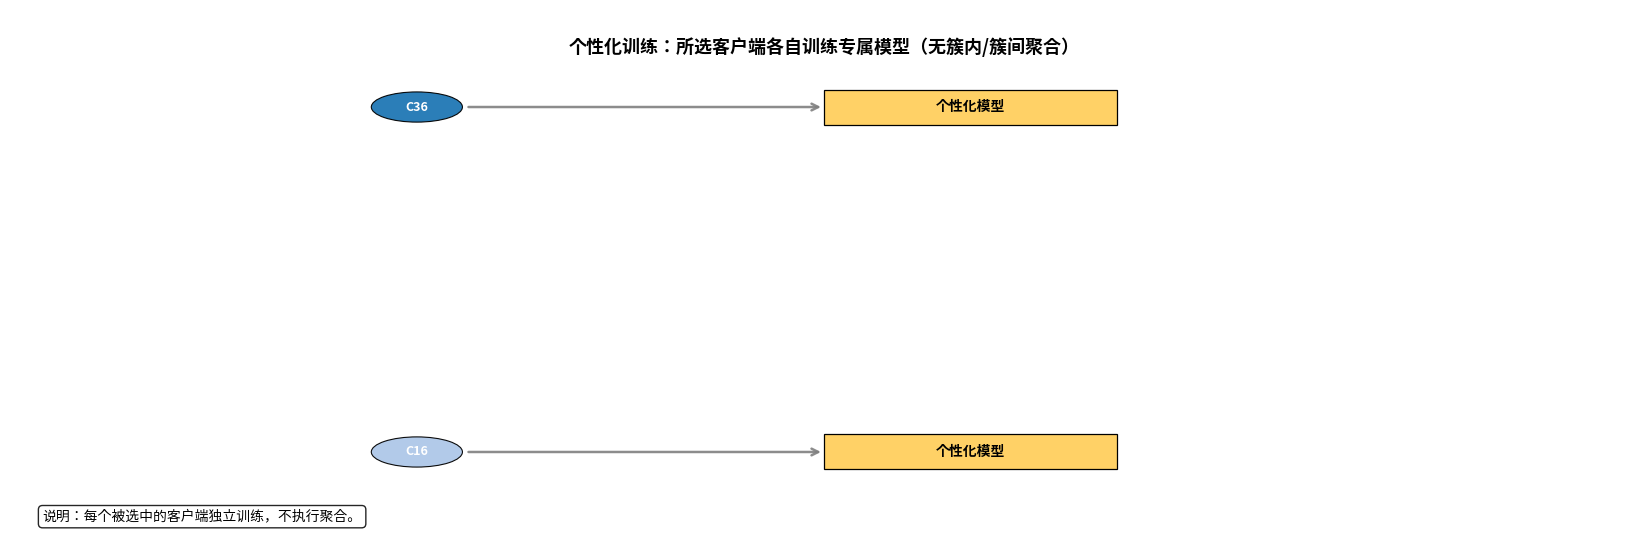

In [5]:
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Rectangle, Circle

# 4) 个性化训练示意图（直接用所选客户端训练各自的个性化模型）
with open('/home/liruobin/FL/FederatedScope/draw/slove.txt', 'r', encoding='utf-8') as f:
    log_txt = f.read()

# 解析第0轮被选中的客户端
selected_clients = []
for line in log_txt.splitlines():
    m = re.search(r"Cluster #\d+: \d+ clients - \[([^\]]+)\]", line)
    if m:
        for token in m.group(1).split(','):
            token = token.strip()
            if token.isdigit():
                selected_clients.append(int(token))

# 去重并限制数量以便排版
unique_clients = []
seen = set()
for cid in selected_clients:
    if cid not in seen:
        seen.add(cid)
        unique_clients.append(cid)
if not unique_clients:
    unique_clients = list(range(1, 19))
clients_to_show = unique_clients[:2]

# 画布
fig, ax = plt.subplots(figsize=(21, 7))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')
ax.text(0.5, 0.95, '个性化训练：所选客户端各自训练专属模型（无簇内/簇间聚合）', ha='center', va='top', fontsize=13, weight='bold')

# 将客户端以网格排列，并为每个客户端绘制其“个性化模型”
cols = 1
rows = len(clients_to_show)
xs = np.array([0.25])
ys = np.linspace(0.82, 0.18, max(rows, 1))

for idx, cid in enumerate(clients_to_show):
    r = idx // cols
    c = idx % cols
    if r >= len(ys):
        break
    x = xs[c]
    y = ys[r]

    # 客户端节点
    client = Circle((x, y), radius=0.028, facecolor=plt.cm.tab20(idx % 20), edgecolor='k', lw=0.8, alpha=0.95)
    ax.add_patch(client)
    ax.text(x, y, f'C{cid}', ha='center', va='center', fontsize=9, color='white', weight='bold')

    # 个性化模型（纵向排布在右侧）
    w, h = 0.18, 0.065
    rx, ry = x + 0.25, y - h/2
    rect = Rectangle((rx, ry), w, h, facecolor='#FFD166', edgecolor='k', lw=0.9)
    ax.add_patch(rect)
    ax.text(rx + w/2, y, '个性化模型', ha='center', va='center', fontsize=10, weight='bold')

    # 训练箭头（从客户端指向其模型）
    arr = FancyArrowPatch((x + 0.03, y), (rx, y), arrowstyle='->', mutation_scale=12, lw=1.8, color='gray', alpha=0.9)
    ax.add_patch(arr)

# 说明
ax.text(0.02, 0.06, '说明：每个被选中的客户端独立训练，不执行聚合。', ha='left', va='center', fontsize=10,
        bbox=dict(boxstyle='round', fc='white', ec='black', alpha=0.85))

plt.show()
